# Non-Negative Matrix Factorization for Image Compression and Clustering

This is the Python Jupyter Notebook for the Medium article on the from scratch implementation of the Non-Negative Matrix Factorization (NNMF) algorithm in Python. It illustrates the basic implementation of the algorithm and explores some of its features in the context of 
1. Image compression 
2. Clustering of neural signals.

As we will do the implementation of the NNMF algorithm ourselves we will only import the basic Python libraries in the first step. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

A detailed explanation of the intuition behind the NNMF algorithm can be found in the accompanying Medium article to this notebook which is why we will keep this part short here. In brief, what we want to achieve in NNMF is to represent any positive, numerical matrix as the product of two lower dimensional matrices. This allows us to 1) reduce the size of an image file and 2) cluster datasets by their most prominent features. So what we want to do is the following: 

$$ V = WH$$

Where *V* is our original input matrix, e.g. an image, *W* is our feature matrix and *H* contains the weights of the features. This way we can reconstruct *V* from *WH*. 
The hard part however is to find *W* and *H*. There are several ways of doing so but here we will stay with the multiplicative update rule derived from the loss function based on the square of the Euclidian distance between *V* and *WH*. 

$$L(V, HW)={\lVert V-WH \rVert}^2$$

Using this this loss function will give rise to the following update rule for H and W:

$$H^{n+1}_{[i,j]} \leftarrow H^{n}_{[i,j]} \frac{((W^n)^T V))_{[i,j]}}{((W^n)^T W^n H^n)_{[i,j]}}$$
$$W^{n+1}_{[i,j]} \leftarrow W^{n}_{[i,j]} \frac{(V (H^{n+1})^T))_{[i,j]}}{(W^n H^{n+1} (H^{n+1})^T)_{[i,j]}}$$

If you want to understand this in more detail I recommend to look into the publication by [Lee and Seung](https://papers.nips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf).

As you can see from the above *H* and *W* are updated sequentially staring with *H*. The updated *H* is then used to update *W*.  
Translating the update rule from above into Python code we end up with the following two functions:

In [2]:
def update_H(W, H, V):
    numerator = W.T.dot(V)
    denominator = W.T.dot(W).dot(H) + 1e-10
    H = H*(numerator / denominator)
    return H

def update_W(W, H, V):
    numerator = V.dot(H.T)
    denominator = W.dot(H).dot(H.T) + 1e-10
    W = W*(numerator / denominator)
    return W

So now that we implemented the update rules for *H* and *W* we need to put them into context. This means we have to 1) initialize them and 2) update them in an iterative manner.  

The initialization will be done by choosing random positive numbers with matrix dimensions that will resemble the dimensions of the original input matrix *V* after the multiplication of *W* and *H*. Further we need to choose the second dimension for both matrices *W* and *H*. This is called the *rank* in NNMF and will determine the quality of the image compression or the number of clusters we will find in our dataset.  

The function below takes care of all the above. By default we run the algorithm for 100 iterations with a rank of 10. If this is the best default setting we will see later in this notebook. As we initialize *W* and *H* with random numbers our loss will be large in the beginning.

$$L(V, HW)=max(L(V, HW))$$

The loss is expected to decline with every iteration until it reaches a minimum . However, it should be noted here that this minimum does not have to be the global minimum but rather represents a local minimum. Therefore running the NNMF algorithm multiple times will avoid getting stuck in unfortunate, local minimum with a large error.

In [3]:
def do_nnmf(V, rank=10, iter=100):
    
    # Initialize 
    n, m = V.shape
    
    W = np.abs(np.random.randn(1, n, rank))[0]
    H = np.abs(np.random.randn(1, rank, m))[0]
    
    loss = []
    for i in range(iter):
        H = update_H(W, H, V)
        W = update_W(W, H, V)
        
        loss.append(sum((V - W.dot(H)).flatten()**2))

    return H, W, loss

That is it. A simple, basic implementation of NNMF with Python from scratch.\
Now let's open an image and see how we can use our NNMF function to compress it. 

## Image compression

We will load the image with [Matplotlib](https://matplotlib.org/) and then pick only one of the color channels to keep things simple. The two versions of our test image are visualized below.

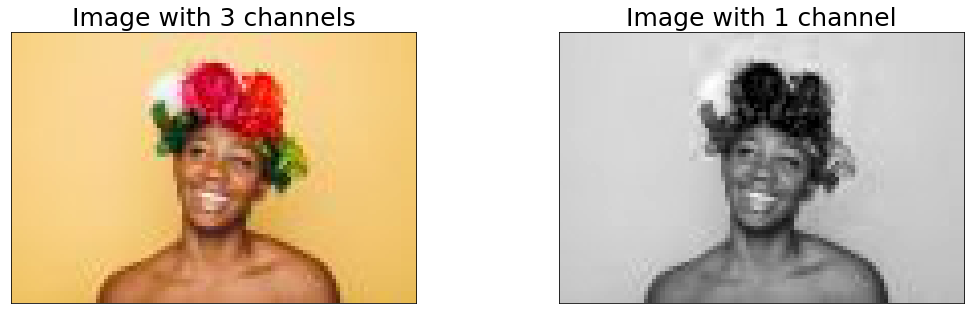

In [4]:
img = plt.imread("./images/small.jpg")
V = img[:, :, 1] # only use one color channel

# Visualize the image
fig, ax = plt.subplots(1, 2, figsize=[18, 5])

ax[0].imshow(img)
ax[0].set_title('Image with 3 channels', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title('Image with 1 channel',fontsize=25)
ax[1].imshow(V, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

Alright so now that we loaded and prepared our image we can hand it over to our NNMF function. As mentioned above let's also increase the default values a little to see if they make sense.

In [5]:
H, W, loss = do_nnmf(V, rank=20, iter=300)

By default our NNMF function will also output the loss in each iteration. So before we look at the result in detail we should first check if the algorithm behaves as expected, meaning the loss decreases with every iteration and to verify our choice of default settings.

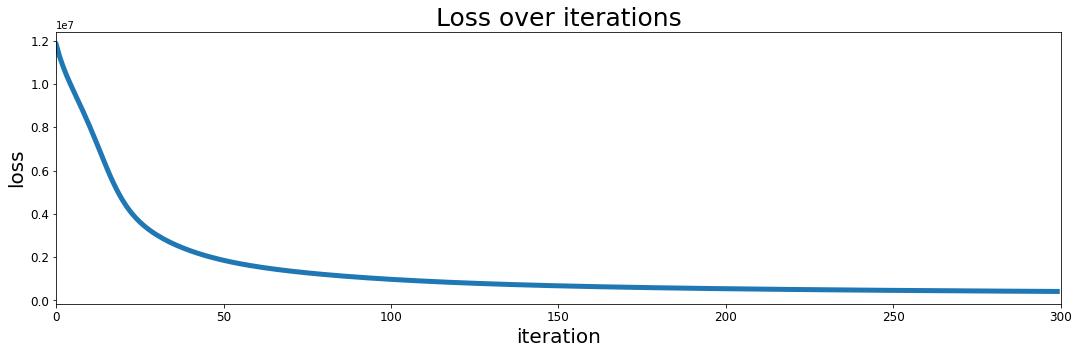

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(loss, lw=5)
ax.set_title('Loss over iterations', fontsize=25)
ax.tick_params(labelsize=12)
ax.set_xlim(0, 300)
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('loss', fontsize=20)

plt.show()

Ok that looks good. The loss decreases with every iteration until it reaches a minimum. However going for only 100 iterations seems a bit tight as the loss still decreases after 100 iterations. So we better keep it at 300. 

Now the big question(s): How does the reconstructed image look like annd how does the choice of rank influences the result?  

Let's have a look!

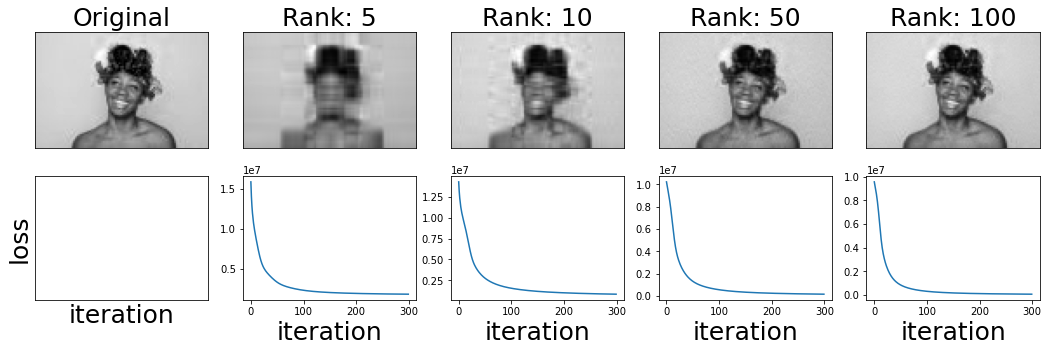

In [7]:
ranks_to_test = [5, 10, 50, 100]

n_plots = len(ranks_to_test) + 1
fig, ax = plt.subplots(2, n_plots, figsize=[18, 5])

# Plot original image as reference
ax[0][0].imshow(V, cmap='gray')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title('Original', fontsize=25)

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_xlabel('iteration', fontsize=25)
ax[1][0].set_ylabel('loss', fontsize=25)

data_points_original = V.shape[0] * V.shape[1]

data_points = []

n = 1
for i in ranks_to_test:
    
    H, W, loss = do_nnmf(V, rank=i, iter=300)
    
    # Reconstruct the image from W and H
    V_rec = W.dot(H)

    data_points.append((H.shape[0] * H.shape[1]) + (W.shape[0] * W.shape[1]))
    
    ax[0][n].imshow(V_rec, cmap='gray')
    ax[0][n].set_xticks([])
    ax[0][n].set_yticks([])
    ax[0][n].set_title('Rank: {}'.format(i), fontsize=25)
    
    ax[1][n].plot(loss)
    ax[1][n].set_xlabel('iteration', fontsize=25)

    n += 1
    
plt.show()

As expected a low rank of 5 returns a poor image in terms of quality whereas a rank of 50 almost keeps the quality of the original image. With a rank of 100 there is no obvious loss in image quality anymore. However, the dimensionality of *W* and *H* is now higher than the original image. This does not make sense in practice since the representation of the original image is now larger than the original without any gain in image quality.

But we do not have to go as far as a rank of 100 to inflate the size of the image through "compression". As we can see from the code and figure below also a rank of 50 results in more data points necessary to represent the image than the original matrix.

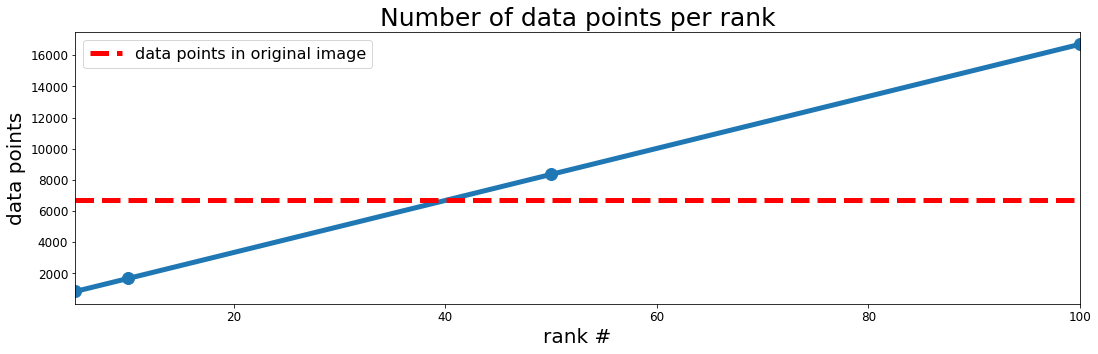

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(ranks_to_test, data_points, marker='o', lw=5, markersize=12)
ax.plot((ranks_to_test[0], ranks_to_test[-1]), 
        (data_points_original, data_points_original), 
        'r--', lw=5,
        label='data points in original image')

ax.set_title('Number of data points per rank', fontsize=25)
ax.tick_params(labelsize=12)
ax.set_xlim(ranks_to_test[0], ranks_to_test[-1])
ax.set_xlabel('rank #', fontsize=20)
ax.set_ylabel('data points', fontsize=20)
ax.legend(fontsize=16)

plt.show()

Given these insights a rank of 20 looks reasonable. We should have a decent image quality but only half the data points to store. 

To have also a more visual understanding of the NNMF procedure let's plot the matrices *W* and *H* for the rank of 20 together with the resulting image. As we can see *W* has the same number of rows (67) as the resulting image while *H* has the same number of columns (100). While both matrices *W* and *H* look nothing like the original image their matrix product resembles the original image quite well.

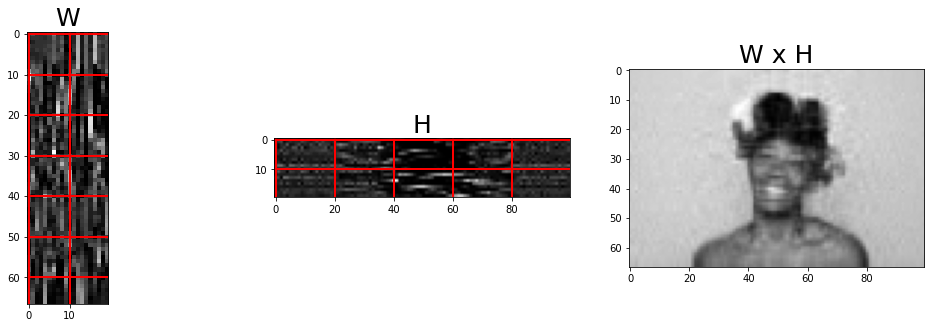

In [9]:
H, W, _ = do_nnmf(V, rank=20, iter=300)
V_rec = W.dot(H)

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

ax[0].imshow(W, cmap='gray')
ax[0].grid(color='r', linestyle='-', linewidth=2)
ax[0].set_title('W', fontsize=25)

ax[1].imshow(H, cmap='gray')
ax[1].grid(color='r', linestyle='-', linewidth=2)
ax[1].set_title('H', fontsize=25)

ax[2].imshow(V_rec, cmap='gray')
ax[2].set_title('W x H', fontsize=25)

plt.show()

## Clustering

Next let's have a look on the clustering properties. As we said before the columns in our matrix W contain the features of the original matrix V. So this means matrix H contains the weights which allow us to reconstruct V through a linear combination with the features in W. As a result we can search for the columns with the maximum weight for each row in H which then is the cluster ID for the respective column in V. This may sound a bit abstract but will become more clear in the following.

For the clustering we will use recordings of electrical brain signals. These signals are acquired by inserting tiny electrodes directly into the brain. The electrical signals that are picked up by these micro-electrodes contain the activity patterns of individual nerve cells, so called neurons. However, as there are billions of such neurons densely packed in the brain each electrode will pick up the signatures of multiple cells in its near vicinity. Each cell produces a different kind of spike when active which allows us to differentiate neurons by their spike waveforms. If you want more background information you can have a look at this article about [extracting neural events from raw data](https://towardsdatascience.com/using-signal-processing-to-extract-neural-events-in-python-964437dc7c0) and this one on [spike-sorting](https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316).

The data we are going to use here for testing the clustering properties of NNMF is coming from a [public dataset hosted on Kaggle](https://www.kaggle.com/joseguzman/waveforms) by [Jose Guzman](https://www.kaggle.com/joseguzman). I also recommend to check out his [notebook](https://www.kaggle.com/joseguzman/spike-classification-based-on-waveforms) which gives additional insights into how to cluster neuronal spikes. Also you can use his results as a benchmark comparison.

In [10]:
# Load the data
data = pd.read_csv('./data/waveforms.csv')
data = data.iloc[:, 1:-1].to_numpy()

# Ensure only values > 0 are in the data by adding the absolute of the smallest value too all values. 
# This way the smallest negsative value will become 0.
data = data.T + np.abs(np.min(data))

As you can see from the code above there is one additional thing we had to do before using the data. We had to make sure all values are positive. This is, as the name says, a precondition for NNMF to work. Here we did this by adding the absolute of the smallest value in the matrix to all other values. By this we "lift" all values above 0.

As you can see in the code below we run our NNMF function the same way as before only this time we choose the rank according to the number of clusters we expect to see in the dataset. In other words we tell the NNMF function that we think we recorded signals from three neurons. You can play around with the rank number and see what clusters you can find.

In [11]:
n_rank = 3
H, W, loss = do_nnmf(data, rank=n_rank, iter=1000)

The code and figure below shows the visualization of the resulting three clusters. The colored lines in the background represent the individual spike waveforms while the black, dashed line shows the mean of all waveforms in the respective cluster. As you can see most waveforms within a cluster share a common shape. For comparison the plot on the left shows all waveforms in the dataset in an un-clustered manner.

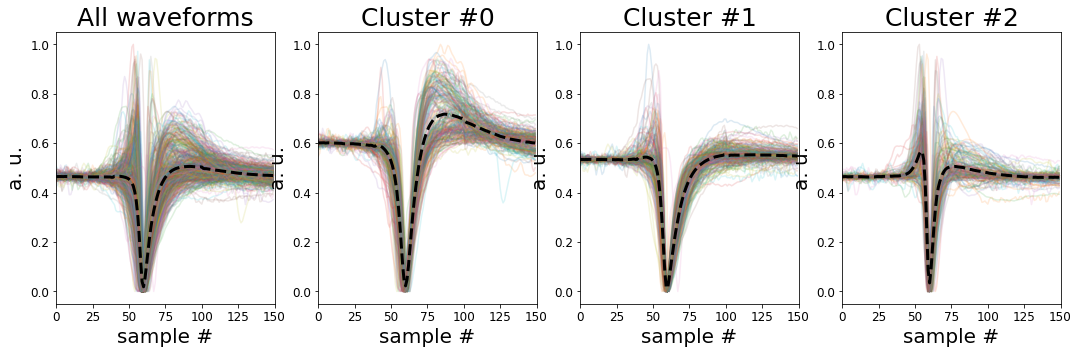

In [12]:
cluster_id = []
for x in range(H.shape[1]):
    cluster_id.append(np.where(np.max(H[:, x]) == H[:, x])[0][0])
    
fig, ax = plt.subplots(1, n_rank + 1, figsize=[18, 5])

all_waveforms = data / np.max(data)
mean_all_waveforms = np.mean(all_waveforms, axis=1)

ax[0].plot(all_waveforms, alpha=0.15)
ax[0].plot(mean_all_waveforms, color='black', linewidth=3, linestyle='dashed')
ax[0].set_title('All waveforms', fontsize=25)
ax[0].set_xlim(0, data.shape[0])
ax[0].set_xlabel('sample #', fontsize=20)
ax[0].set_ylabel('a. u.', fontsize=20)  
ax[0].tick_params(labelsize=12)


for cluster in range(n_rank):
    cluster_index = np.where([x == cluster for x in cluster_id])

    waveforms = data.T[cluster_index].T
    waveforms = waveforms / np.max(waveforms)
    mean_waveform = np.mean(waveforms, axis=1)

    ax[cluster + 1].plot(waveforms, alpha=0.15)
    ax[cluster + 1].plot(mean_waveform, color='black', linewidth=3, linestyle='dashed')
    ax[cluster + 1].set_title('Cluster #{}'.format(cluster), fontsize=25)
    ax[cluster + 1].set_xlim(0, waveforms.shape[0])
    ax[cluster + 1].set_xlabel('sample #', fontsize=20)
    ax[cluster + 1].set_ylabel('a. u.', fontsize=20)    
    ax[cluster + 1].tick_params(labelsize=12)
    
plt.show()